# Demand Elasticity

This example demonstrates how demand elasticity can be modelled in PyPSA, using single node capacity expansion model in the style of [model.energy](https://model.energy).

See [Brown, Neumann, Riepin (2025)](https://doi.org/10.1016/j.eneco.2025.108483) for more details.

## Preparations

We start by loading packages, example networks and creating a utility function to retrieve price duration curve.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pypsa

plt.style.use("bmh")

In [2]:
def get_price_duration(n: pypsa.Network, bus: str = "electricity") -> pd.Series:
    s = (
        n.buses_t.marginal_price[bus]
        .sort_values(ascending=False)
        .reset_index(drop=True)
    )
    s.index = np.arange(0, 100, 100 / len(s.index))
    return s

In [3]:
n = pypsa.examples.model_energy()
n.remove("Load", "demand")
n.remove("Generator", "load shedding")

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v0.35.0/examples/networks/model-energy/model-energy.nc.
INFO:pypsa.network.io:New version 0.35.1 available! (Current: 0.35.0)
INFO:pypsa.network.io:Imported network 'Model-Energy' has buses, carriers, generators, links, loads, storage_units, stores


To save some computation time, we will sample just every fifth day of the year. Each day is considered at 3-hourly resolution, so we will have 8 snapshots per representative day.

In [4]:
selected = n.snapshots.normalize().unique()[::5]
snapshots = n.snapshots[n.snapshots.normalize().isin(selected)]
n.set_snapshots(snapshots)
n.snapshot_weightings[["objective", "generators"]] *= 5

## Perfectly inelastic demand

Most commonly, capacity expansion models would prescribe a perfectly inelastic demand via the `p_set` attribute, e.g. 100 MW.

The utility drawn from this consumption is effectively infinite. The model has to find a way to satisfy it. Otherwise, the model is infeasible.

In [5]:
n.add("Load", "demand", bus="electricity", p_set=100)

Index(['demand'], dtype='object')

In [6]:
n.optimize()

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.09s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-pky581l4 has 11686 rows; 5262 cols; 23080 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
Presolving model
6722 rows, 4976 cols, 17830 nonzeros  0s
Dependent equations search running on 1752 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
6138 rows, 4392 cols, 16662 nonzeros  0s
Presolve : Reductions: rows 6138(-5548); columns 4392(-870); elements 16662(-6418)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 584(48300) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5262 primals, 11686 duals
Objective: 9.06e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


       4327     9.0557108452e+07 Pr: 0(0); Du: 0(4.37836e-11) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-pky581l4
Model status        : Optimal
Simplex   iterations: 4327
Objective value     :  9.0557108452e+07
P-D objective error :  4.9364963280e-16
HiGHS run time      :          0.31
Writing the solution to /tmp/linopy-solve-tkdujqiu.sol


('ok', 'optimal')

Market clearing prices can spike to extreme values in few hours of the year, while remaining close to zero for a majority of time.

<Axes: xlabel='Fraction of Time [%]', ylabel='Clearing Price [€/MWh]'>

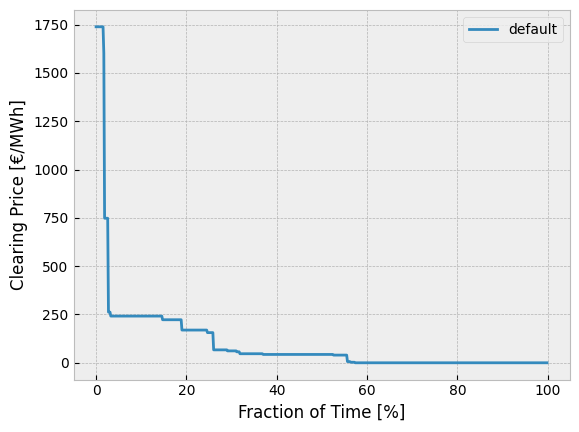

In [7]:
fig, ax = plt.subplots()
get_price_duration(n).plot(
    ax=ax,
    ylabel="Clearing Price [€/MWh]",
    xlabel="Fraction of Time [%]",
    label="default",
    legend=True,
)

In [8]:
capacities = n.statistics.optimal_capacity(round=2).to_frame("inelastic")
capacities

inelastic
component   carrier                    
Generator   solar                411.73
            wind                 361.42
Link        electrolysis          27.27
            turbine               81.35
StorageUnit battery storage      265.98
Store       hydrogen storage    8174.64

## Perfectly inelastic demand up to VOLL

One way to avoid the price spikes is to model demand as perfectly inelastic up to a pre-defined value of lost load (VOLL).

Effectively, this is defined by a utility function $U(d) = Vd$ with a constant value $V$ for consumption $d\in[0,D]$, for instance 1000 €/MWh.

The demand curve is a step function. It is perfectly inelastic up to a price of $V$ at which point it is perfectly elastic.

When we make the substitution $d=D-g$, we see that we can model the VOLL case with a load shedding generator with marginal costs of $V=1000$ €/MWh, omitting the constant term $VD$.

$U(d) = Vd$

$U(d) = VD - Vg$

Note that the objective sense of PyPSA is to minimise costs in order to maximise utility, so any costs have a postive sign and utility gains have a negative sign in the objective.

In [9]:
n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost=1000,
    p_nom=100,
)

Index(['load-shedding'], dtype='object')

In [10]:
n.optimize()

Index(['load-shedding'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.12s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-vattrlyd has 12854 rows; 5846 cols; 24832 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
Presolving model
6722 rows, 5560 cols, 18414 nonzeros  0s
Dependent equations search running on 1752 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
6138 rows, 4976 cols, 17246 nonzeros  0s
Presolve : Reductions: rows 6138(-6716); columns 4976(-870); elements 17246(-7586)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 584(48100) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5846 primals, 12854 duals
Objective: 8.96e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


       3902     8.9608025613e+07 Pr: 0(0); Du: 0(1.24487e-11) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-vattrlyd
Model status        : Optimal
Simplex   iterations: 3902
Objective value     :  8.9608025613e+07
P-D objective error :  1.6629270658e-16
HiGHS run time      :          0.29
Writing the solution to /tmp/linopy-solve-flgyyxlk.sol


('ok', 'optimal')

Now, the peak price is capped at 2000 €/MWh:

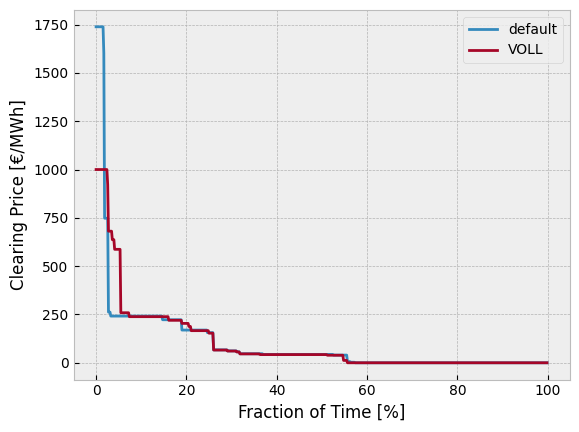

In [11]:
get_price_duration(n).plot(ax=ax, label="VOLL", legend=True)
fig

This results in some changes in the cost-optimal capacity mix, in particular in terms of backup capacities.

In [12]:
capacities["VOLL"] = n.statistics.optimal_capacity(round=2)
capacities

inelastic     VOLL
component   carrier                             
Generator   solar                411.73   408.13
            wind                 361.42   364.43
Link        electrolysis          27.27    24.95
            turbine               81.35    57.28
StorageUnit battery storage      265.98   265.72
Store       hydrogen storage    8174.64  7286.57

## Linear demand curve

In reality, electricity demand is at least partially elastic. Consumers would use less electricity if its more expensive, or would use more electricity if prices are low. 

For a linear demand curve $p = a - bd$, where $p$ is the price, the utility is quadratic: $U(d) = ad - 0.5 b d^2$

For a choice of $a=2000$ and $b=20$, the demand curve looks like this:

Text(0, 0.5, 'Price (€/MWh)')

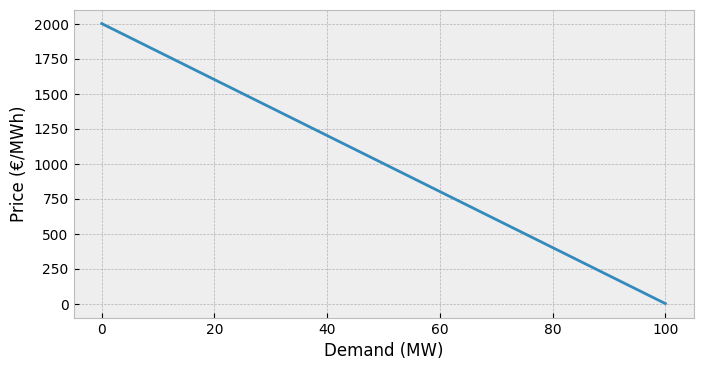

In [13]:
x = np.linspace(0, 100, 200)
plt.figure(figsize=(8, 4))
plt.plot(x, 2000 - 20 * x)
plt.xlabel("Demand (MW)")
plt.ylabel("Price (€/MWh)")

That means, for instance, at a price of 1000 €/MWh, the demand would be only 50 MW. At a price of 400 €/MWh, 80 MW. And so on.

Applying the same substition $d = a/b - g$ ($a/b$ yields the maximum consumption at the zero point), turns 

$U(d) = ad - 0.5 b d^2$

into 

$U(g) = \frac{a^2}{2b} - 0.5 b g^2$

which represents a load shedding generator with quadratic marginal cost $b/2$, again omitting the constant term from the objective.

Due to the quadratic terms in the objective function, this addition turns the model into a quadratic problem (QP).

In [14]:
n.remove("Generator", "load-shedding")

n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost_quadratic=20 / 2,
    p_nom=100,
)

Index(['load-shedding'], dtype='object')

In [15]:
n.optimize(solver_name="highs")

Index(['load-shedding'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.1s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
QP   linopy-problem-2dnudsfs has 12854 rows; 5846 cols; 24832 matrix nonzeros; 5846 Hessian nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
  Iteration        Objective     NullspaceDim
          0    5.0822074e+10                0      0.03s
        100    3.8103124e+08                0      0.04s
        400    2.0725883e+08                8      0.14s
        600    1.7807416e+08               17      0.18s
        700    1.7653604e+08               23      0.20s
        800    1.6555648e+08               23      0.22s
        900    1.6188991e+08               25      0.24s
       1000    1.6080767e+08               29      0.26s
       3000    1.3041523e+08              103      0.84s
       4000    1.1723995e+08              113      1.24s
       6000    1.0093707e+08              171      2.14s
       7000        

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5846 primals, 12854 duals
Objective: 8.05e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


      23900         80515428              673     13.99s
Model name          : linopy-problem-2dnudsfs
Model status        : Optimal
Simplex   iterations: 888
QP ASM    iterations: 23900
Objective value     :  8.0515362747e+07
P-D objective error :  8.1000324240e-07
HiGHS run time      :         14.00
Writing the solution to /tmp/linopy-solve-x7f605om.sol


('ok', 'optimal')

The price duration curve is considerably smoother with less extreme prices and fewer zero-price hours:

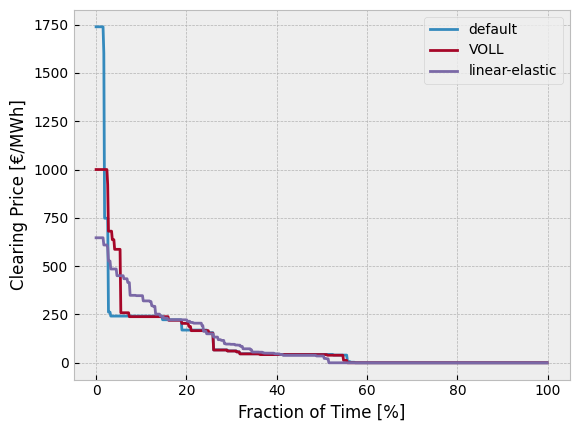

In [16]:
get_price_duration(n).plot(ax=ax, label="linear-elastic", legend=True)
fig

Also, the optimised capacity mix is drastically different. The model cuts down on balancing technologies and rather curtails a lot demand instead. 

In [17]:
capacities["linear-elastic"] = n.statistics.optimal_capacity(round=2)
capacities

inelastic     VOLL  linear-elastic
component   carrier                                             
Generator   solar                411.73   408.13          390.26
            wind                 361.42   364.43          326.02
Link        electrolysis          27.27    24.95            8.42
            turbine               81.35    57.28           15.43
StorageUnit battery storage      265.98   265.72          253.90
Store       hydrogen storage    8174.64  7286.57         2311.79

The drawback and explanation here is that the linear demand curve becomes unrealistically elastic at higher prices.

## Partial demand elasticity

It is also possible to mix different demand modelling approaches. For instance, keeping 80% of demand perfectly inelastic, while modelling 20% with a linear demand curve.

This just requires adjusting the capacity and cost terms of the load shedding generator (adjusts the slope of the linear demand curve)

In [18]:
n.generators.loc["load-shedding", "p_nom_max"] *= 0.2
n.generators.loc["load-shedding", "marginal_cost_quadratic"] /= 0.2

## Piecewise-linear demand curve

It is also possible to model a set of piecewise linear demand curves, e.g. to approximate a log-log demand curve ($\ln p = a - b \ln d$), without much modification.

For details see [Brown, Neumann, Riepin (2025)](https://doi.org/10.1016/j.eneco.2025.108483), Section 3.2 and Appendix A. 